<a href="https://colab.research.google.com/github/BetikuOluwatobi/sentiment_analysis_with_transformers/blob/main/sentiment_analysis_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jul 28 10:40:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install Hugging Face Transformers

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.2 MB/s eta 0:00:00


### Import all neccesary libraries

In [3]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, TFAutoModel
import pathlib,os,json
import tensorflow as tf

#### Get Dataset from Kaggle using Kaggle Api

In [4]:
api_key = {"username":"your_username","key":"your_api_key"} #Get your api key from kaggle settings
kaggle_path = pathlib.Path('/root/.kaggle') #specify the root directory using pathlib
os.makedirs(kaggle_path,exist_ok=True)
with open(kaggle_path/'kaggle.json','w') as handl:
  json.dump(api_key,handl) #dump a kaggle.json file containi g your credentials in the root directory, this is essential for the kaggle api

os.chmod(kaggle_path/'kaggle.json', 600)

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

## Download dataset from Kaggle

In [6]:
api.competition_download_file('sentiment-analysis-on-movie-reviews','train.tsv.zip','./')

100%|██████████| 1.28M/1.28M [00:00<00:00, 2.17MB/s]

In [7]:
from zipfile import ZipFile

### Unzip file

In [8]:
with ZipFile('./train.tsv.zip','r') as file:
  file.extractall('./data')

In [9]:
df = pd.read_csv('./data/train.tsv',sep='\t')

In [10]:
df.head(5)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [11]:
len(df)

156060

In [12]:
df = df.drop_duplicates('SentenceId',keep='first')

### We will keep duplicates for now as that will boster training

<Axes: >

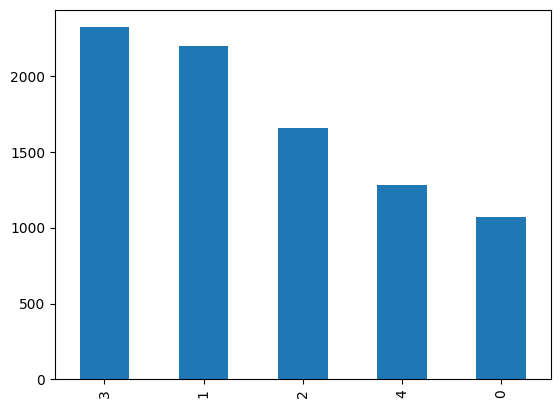

In [13]:
df['Sentiment'].value_counts().plot(kind='bar')

In [14]:
phrase = df['Phrase'].values[0]

In [15]:
print(phrase)

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .


In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [17]:
max_len = 128

tokens = tokenizer(phrase, max_length=max_len,truncation=True,padding='max_length', add_special_tokens=True, return_tensors='np')

In [18]:
print(tokens['input_ids'][0], tokens['attention_mask'][0])

[  101   138  1326  1104 13936 25265 16913 15107  1103  8050  2553  1115
  1184  1110  1363  1111  1103 20398  1110  1145  1363  1111  1103   176
  9900   117  1199  1104  1134  5411  1821 14225  1133  3839  1104  1134
  7919  1106  1277  1104   170  1642   119   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

### Construct Input Pipeline

In [19]:
def to_feature(text, max_len=max_len, padding='max_length'):
  tokens = tokenizer(text.numpy().decode(), max_length=max_len,truncation=True,padding='max_length', add_special_tokens=True, return_tensors='tf')
  return (tokens['input_ids'], tokens['attention_mask'])

def to_feature_map(text, label):
  input_ids, attention_mask = tf.py_function(to_feature, inp=[text,], Tout=[tf.int32,tf.int32])
  input_ids, attention_mask = input_ids[0], attention_mask[0]
  input_ids.set_shape([max_len])
  attention_mask.set_shape([max_len])
  x = {
      "input_ids": input_ids,
      "attention_mask": attention_mask
  }
  return (x, label)

In [20]:
df['Sentiment'].max() + 1

5

In [21]:
len(df)

8529

### One Hot Encoding the labels

In [22]:
labels = np.zeros((len(df), df['Sentiment'].max() + 1))

In [23]:
labels.shape

(8529, 5)

In [24]:
labels[np.arange(len(df)), df['Sentiment'].values] = 1

In [25]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [26]:
with tf.device('/cpu:0'):
  batch_size = 16
  text_data = df['Phrase'].values
  def make_dataset(text_data=text_data, labels=labels):
      dataset = tf.data.Dataset.from_tensor_slices((text_data, labels))
      dataset = dataset.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE,deterministic=False)
      dataset = dataset.batch(batch_size=batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).shuffle(100000)
      dataset = dataset.prefetch(tf.data.AUTOTUNE)

      return dataset
  dataset = make_dataset()

In [27]:
dataset.element_spec

({'input_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

### Splitting dataset into train_data and valid_data

In [28]:
train_split = int(len(df)/batch_size * 0.835)
train_dataset = dataset.take(train_split)
valid_dataset = dataset.skip(train_split)

In [29]:
train_dataset.element_spec

({'input_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [30]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [31]:
def create_model():
  input_ids = tf.keras.layers.Input(shape=(max_len,), batch_size=batch_size, name='input_ids',dtype=tf.int32)
  attention_mask = tf.keras.layers.Input(shape=(max_len,), batch_size=batch_size, name='attention_mask',dtype=tf.int32)
  embeddings = bert.bert(input_ids, attention_mask=attention_mask)[1]
  drop = tf.keras.layers.Dropout(0.4)(embeddings)
  dense = tf.keras.layers.Dense(128, activation='relu')(drop)
  output = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(dense)

  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

  return model

In [32]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, weight_decay=0.05),
              loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(name= "accuracy",)])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(16, 128)]          0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(16, 128)]          0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(16, 128, 7                                           

### after testing different epochsj

In [34]:
epochs = 8
history = model.fit(train_dataset,validation_data=valid_dataset,batch_size=batch_size, epochs=epochs)

Epoch 1/8
445/445 [==============================] - 278s 481ms/step - loss: 1.3892 - accuracy: 0.3868 - val_loss: 1.0390 - val_accuracy: 0.5426
Epoch 2/8
445/445 [==============================] - 211s 454ms/step - loss: 1.0762 - accuracy: 0.5284 - val_loss: 0.8476 - val_accuracy: 0.6506
Epoch 3/8
445/445 [==============================] - 211s 453ms/step - loss: 0.8922 - accuracy: 0.6261 - val_loss: 0.6429 - val_accuracy: 0.7713
Epoch 4/8
445/445 [==============================] - 210s 453ms/step - loss: 0.7157 - accuracy: 0.7104 - val_loss: 0.5004 - val_accuracy: 0.8331
Epoch 5/8
445/445 [==============================] - 211s 454ms/step - loss: 0.5361 - accuracy: 0.7941 - val_loss: 0.3602 - val_accuracy: 0.8651
Epoch 6/8
445/445 [==============================] - 210s 453ms/step - loss: 0.4095 - accuracy: 0.8447 - val_loss: 0.2789 - val_accuracy: 0.9126
Epoch 7/8
445/445 [==============================] - 208s 450ms/step - loss: 0.3030 - accuracy: 0.8924 - val_loss: 0.1783 - val_ac

### Evaluate Model

In [44]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
def plot_model(metric="loss", epochs=epochs):
  plt.plot(range(epochs), history.history[metric], c='blue', alpha=0.7, label=f"Training {metric}")
  plt.plot(range(epochs), history.history[f"val_{metric}"], c='red', alpha=0.7, label=f"Validation {metric}")
  plt.title(f"Training Vs Validation {metric}")
  plt.legend(loc="best")
  plt.show()

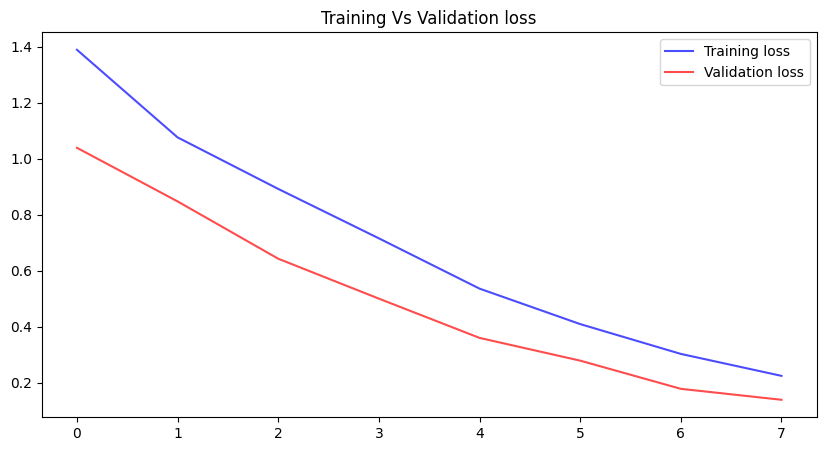

In [45]:
plot_model(metric="loss")

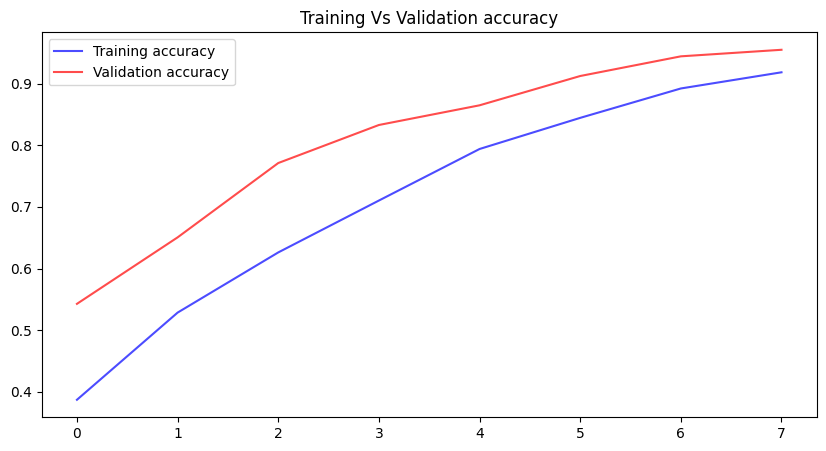

In [46]:
plot_model(metric="accuracy")

### Making Predictions

In [47]:
api.competition_download_file('sentiment-analysis-on-movie-reviews','test.tsv.zip','./') #download test data

2023-07-28 11:41:22,336 WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))': /api/v1/competitions/data/download/sentiment-analysis-on-movie-reviews/test.tsv.zip


100%|██████████| 494k/494k [00:00<00:00, 1.08MB/s]

In [48]:
with ZipFile('./test.tsv.zip','r') as file:
  file.extractall('./data')

In [49]:
test_df = pd.read_csv('./data/test.tsv',sep='\t')

In [50]:
test_df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [51]:
test_df = test_df.drop_duplicates("SentenceId", keep="first")

In [54]:
text = test_df["Phrase"].values[2]

In [55]:
tokens = tokenizer(text, truncation=True, max_length=max_len, padding="max_length", return_tensors='tf')

In [62]:
label_map = {0: "negative",1: "Somewhat Negative", 2: "Neutral", 3: "Somewhat Positive", 4: "Positive"}

In [64]:
label_map[model.predict({"input_ids":tokens["input_ids"], "attention_mask": tokens["attention_mask"]}).argmax()]

1/1 [==============================] - 0s 81ms/step


'Positive'

In [68]:
def make_predictions(text,model=model):
  tokens = tokenizer(text, truncation=True, max_length=max_len, padding="max_length", return_tensors='tf')
  pred = model.predict({"input_ids":tokens["input_ids"], "attention_mask": tokens["attention_mask"]}).argmax()
  return label_map[pred]

In [71]:
import ast
def prepare_preds(test_df=test_df):
  test_df["Sentiment"] = test_df["Phrase"].apply(lambda x: make_predictions(x))
  return test_df

In [73]:
test_preds_df = prepare_preds()

1/1 [==============================] - 0s 82ms/step


<ipython-input-71-4f5d1f692257>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Sentiment"] = test_df["Phrase"].apply(lambda x: make_predictions(x))


In [76]:
test_df = test_df.drop(["PhraseId",	"SentenceId"], axis=1)

In [78]:
pd.set_option('display.max_colwidth', None)
test_df.head(10)

,Phrase,Sentiment
0,An intermittently pleasing but mostly routine effort .,Neutral
15,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .",Somewhat Negative
93,Once you get into its rhythm ... the movie becomes a heady experience .,Positive
117,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .,Somewhat Negative
158,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth .",Somewhat Positive
189,"All ends well , sort of , but the frenzied comic moments never click .",Neutral
211,"It 's a hoot and a half , and a great way for the American people to see what a candidate is like when he 's not giving the same 15-cent stump speech .",Somewhat Positive
263,"The weight of the piece , the unerring professionalism of the chilly production , and the fascination embedded in the lurid topic prove recommendation enough .",Neutral
301,"The film contains no good jokes , no good scenes , barely a moment when Carvey 's Saturday Night Live-honed mimicry rises above the level of embarrassment .",Somewhat Negative
344,"An offbeat , sometimes gross and surprisingly appealing animated film about the true meaning of the holidays .",Somewhat Positive


<Axes: >

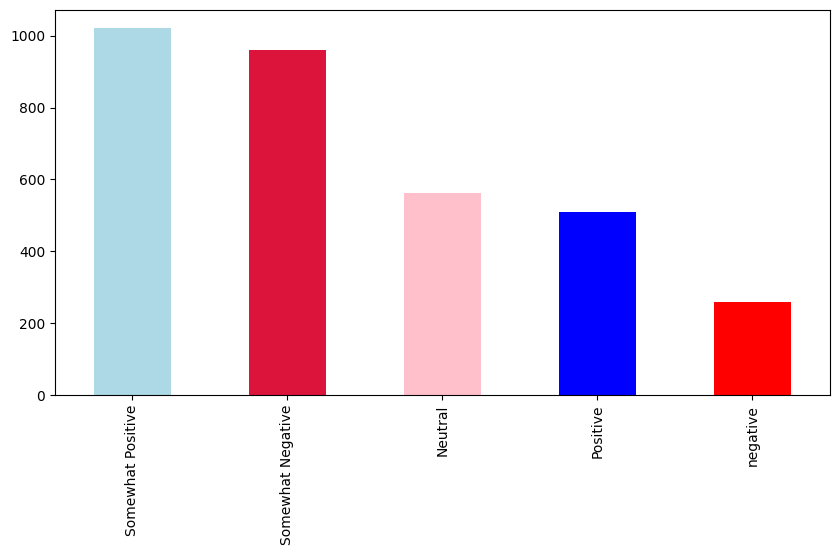

In [89]:
c = ['lightblue', 'crimson', 'pink', 'blue', 'red']
test_df["Sentiment"].value_counts().plot(kind='bar',color=c)